Importing Necessary Libraries

In [7]:
import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
from datetime import datetime,timedelta
import calendar
from prophet import Prophet
import requests
import time
import json
import matplotlib.pyplot as plt
import re
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

Loading News articles from past decade to Compare the Sentiments Analysed by NLTK vs LLM

In [8]:
llm_data = pd.read_csv('articles_sentiment_llm.csv')
llm_data['year_month'] = pd.to_datetime(llm_data['pub_date']).dt.to_period('M')
llm_overall_sentiment = llm_data.groupby('year_month')[['neg', 'neu', 'pos', 'compound']].mean()
llm_overall_sentiment = llm_overall_sentiment.reset_index()


nlp_data = pd.read_csv('articles_sentiment.csv')
nlp_data['year_month'] = pd.to_datetime(nlp_data['pub_date']).dt.to_period('M')
nlp_overall_sentiment = nlp_data.groupby('year_month')[['neg', 'neu', 'pos', 'compound']].mean()
nlp_overall_sentiment = nlp_overall_sentiment.reset_index()

print(llm_overall_sentiment.columns)
print(nlp_overall_sentiment.columns)


Index(['year_month', 'neg', 'neu', 'pos', 'compound'], dtype='object')
Index(['year_month', 'neg', 'neu', 'pos', 'compound'], dtype='object')


Polarity Comparison Over Time - NLTK vs LLM

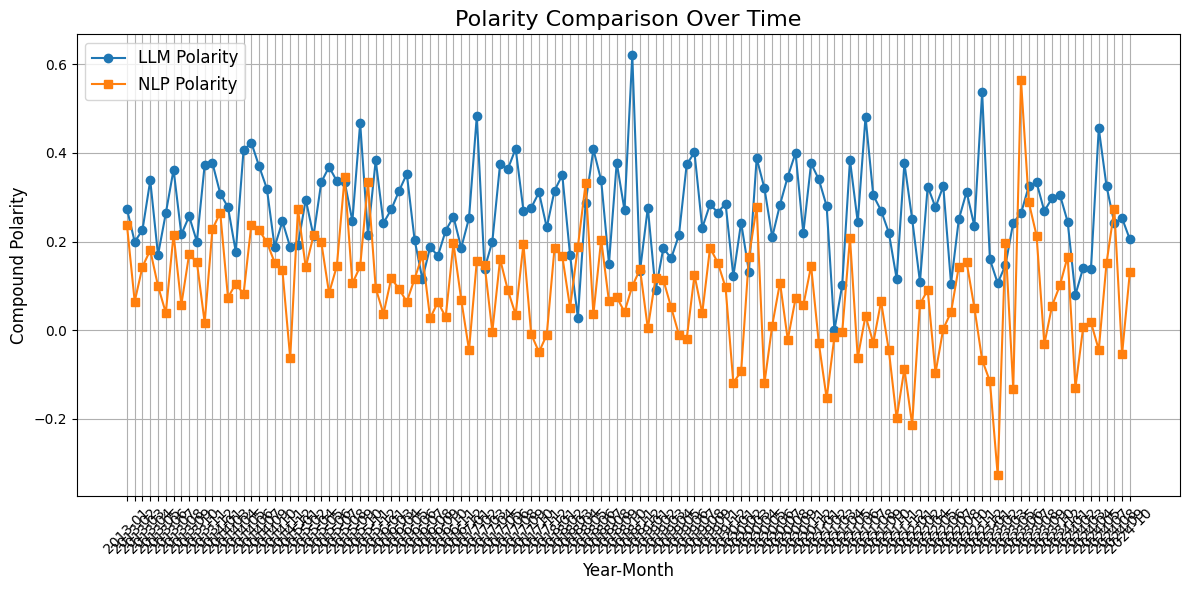

In [9]:
import matplotlib.pyplot as plt

# Ensure year_month is sorted for both datasets
llm_overall_sentiment = llm_overall_sentiment.sort_values(by='year_month')
nlp_overall_sentiment = nlp_overall_sentiment.sort_values(by='year_month')

plt.figure(figsize=(12, 6))

plt.plot(llm_overall_sentiment['year_month'].astype(str), llm_overall_sentiment['compound'], label='LLM Polarity', marker='o')
plt.plot(nlp_overall_sentiment['year_month'].astype(str), nlp_overall_sentiment['compound'], label='NLP Polarity', marker='s')

plt.title('Polarity Comparison Over Time', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Compound Polarity', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


#### Observations:
##### LLM Polarity (Blue Line):

- The LLM polarity scores (blue line) demonstrate a more stable trend over time.
-  There is a consistent range, with the polarity staying mostly positive, suggesting that LLM is more balanced in identifying sentiment and avoids extreme variations.
- Peaks and troughs are present, but they appear smoother compared to NLTK, showing that LLM potentially captures nuances better.
##### NLTK Polarity (Orange Line):

- The NLTK polarity scores (orange line) exhibit more frequent and sharper fluctuations.
- There are significant dips into the negative polarity range, indicating that NLTK is more sensitive to certain words or phrases that might trigger strong negative sentiment.
- The variability and extremes in NLTK scores could point to an overreaction to sentiment-laden words, leading to less consistency.
##### Trend Comparison:

- The LLM seems to capture sentiment more consistently, while NLTK shows a lot of noise (frequent spikes and dips).
- NLTK often underestimates or overestimates sentiment compared to LLM.
##### Alignment Between LLM and NLTK:

- While both models generally follow the same upward or downward trends, the magnitude of change is significantly different.
- LLM appears to smooth out erratic behavior, potentially indicating a better understanding of context.

Defining functions to Handle Different Analysis

- Loading Appl Stock Data From 2013. 
- Using prophet to forecast for the next 10 months.

In [10]:
def get_forecast():
    ticker = "AAPL"
    stock_data = yf.download(ticker, start="2013-01-01", end =datetime.now().strftime("%Y-%m-%d"))
    data = stock_data
    data['Date'] = data.index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    monthly_data = data.resample('M').mean()
    prophet_data = monthly_data.reset_index()[['Date', 'Close']]
    prophet_data.columns = ['ds', 'y']
    p_data = data[['Close']].reset_index()
    p_data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
    model = Prophet()
    model.fit(p_data)
    
############            Getting Daily Forecast                 ###############
    future_dates = model.make_future_dataframe(periods=30)
    forecast_dates = model.predict(future_dates)
    fig = model.plot(forecast_dates)
    plt.title('30-day Forecast of Apple Stock Close Price')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()

############            Getting Monthly Forecast                 ###############
    model = Prophet()
    model.fit(prophet_data)
    future_dates_month = model.make_future_dataframe(periods=10, freq='M')
    forecast_month = model.predict(future_dates_month)
    fig = model.plot(forecast_month)

    plt.title('10-Month Forecast of Apple Stock Close Price')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()

    return forecast_dates, forecast_month


[*********************100%***********************]  1 of 1 completed
00:16:52 - cmdstanpy - INFO - Chain [1] start processing
00:16:54 - cmdstanpy - INFO - Chain [1] done processing


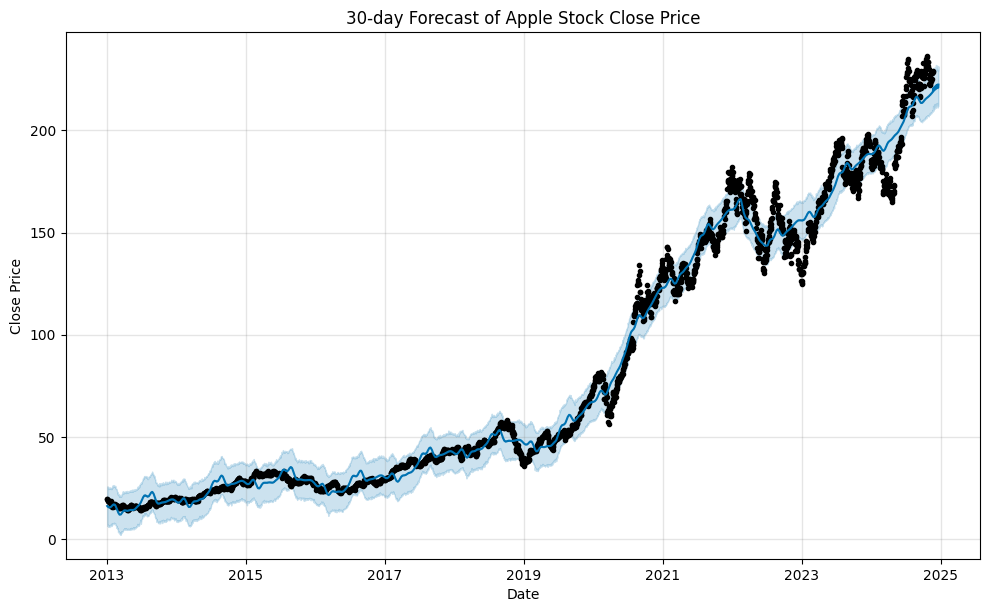

00:16:55 - cmdstanpy - INFO - Chain [1] start processing
00:16:55 - cmdstanpy - INFO - Chain [1] done processing


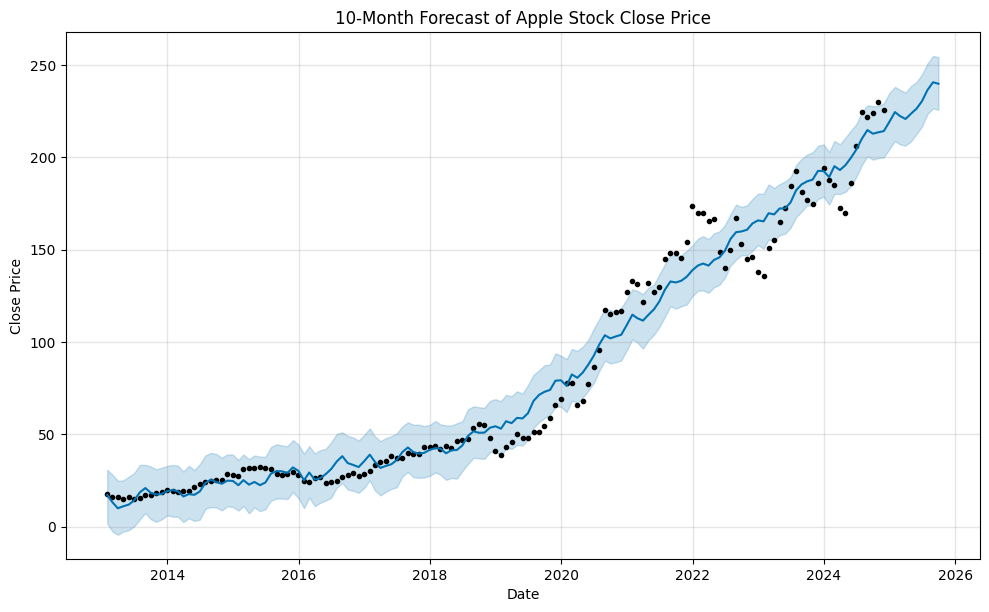

In [11]:
forecast_dates, forecast_month = get_forecast()

Defining Functions 
- to fetch articles for the current month from New york Times in real time.

In [12]:
ollama_url = "http://127.0.0.1:11434/api/generate"

def concatenate_headline(dict_item):
    concatenated = ' '.join([str(value) for value in dict_item.values() if value])
    return concatenated
def get_articles_of_this_month(search_keywords):

    year = datetime.now().strftime('%Y')
    month = datetime.now().strftime('%m')
    

    api_key = "nSJlJTCMVqCArRKWgg3W4tK9LenCmsMd"
    base_url = f"https://api.nytimes.com/svc/archive/v1/{year}/{month}.json"

    url = base_url.format(year=year, month=month)
    params = {'api-key': api_key}
    response = requests.get(url, params=params)
    data = response.json()
    

    all_articles = []
    articles = data['response']['docs']
    for article in articles:
        for keyword in search_keywords:
            if keyword.lower() in article['headline']['main'].lower():
                all_articles.append(article)
                break  
    print(f"Found {len(articles)} articles in {year}-{month}")
    print(f"Found {len(all_articles)} articles in {year}-{month} related to APPL")
    news_data=pd.DataFrame(all_articles)
    filtered_columns_data = news_data[['abstract', 'snippet', 'lead_paragraph', 'headline', 'pub_date']]
    
    filtered_columns_data['headline_combined'] = filtered_columns_data['headline'].apply(concatenate_headline)
    filtered_columns_data = filtered_columns_data.drop('headline', axis=1)
    text = []
    for j in range(filtered_columns_data.shape[0]):
        str1=''
        for i in [0,1,2,4]:
            str1 += filtered_columns_data.iloc[j,i]
        text.append(str1)

    # filtered_columns_data.iloc[:,5:]
    filtered_columns_data['text_in_article'] = text
    return filtered_columns_data

Defining Function to Summarize the articles and provide a gist.

In [13]:
def summarize_text(text):
    payload = {
        "model": "llama2",
        "prompt": f"Summarize the following text:\n\n{text}\n\nSummary:"
    }
    
    try:
        response = requests.post(ollama_url, json=payload, stream=True)
        response.raise_for_status()  # Raise an error for bad status codes
        
        full_response = []
        for line in response.iter_lines():
            if line:
                data = json.loads(line.decode('utf-8'))
                partial_response = data.get("response", "")
                full_response.append(partial_response)
        
        return "".join(full_response)
    
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return ""

Defining Function to Analyse Sentiment from the Summarized News articles

In [14]:
def analyze_sentiment(text):
    payload = {
        "model": "llama2",
        "prompt": f"Analyze the sentiment of the following text and provide just the sentiment scores in the format {{'neg': , 'neu': , 'pos': , 'compound': }}:\n\n{text}\n\nSentiment Scores: in 2 decimals . Please do not output any other text in your response"
    }
    
    try:
        response = requests.post(ollama_url, json=payload, stream=True)
        response.raise_for_status()  # Raise an error for bad status codes
        # print(f"Response Status: {response.status_code}")

        full_response = []
        for line in response.iter_lines():
            if line:
                data = json.loads(line.decode('utf-8'))
                partial_response = data.get("response", "")
                full_response.append(partial_response)
        
        response_text = "".join(full_response)
        # print(f"Response Text: {response_text}")

        scores = {
            "neg": 0.0,
            "neu": 0.0,
            "pos": 0.0,
            "compound": 0.0
        }
        
        match = re.search(r"\{(.*)\}", response_text)
        if not match:
            return scores

        match_groups = match.group(1).split(',')
        if len(match_groups) > 0:
            scores['neg'] = float(match_groups[0].split(': ')[1])
        if len(match_groups) > 1:
            scores['neu'] = float(match_groups[1].split(': ')[1])
        if len(match_groups) > 2:
            scores['pos'] = float(match_groups[2].split(': ')[1])
        if len(match_groups) > 3:
            scores['compound'] = float(match_groups[3].split(': ')[1])
        
        return scores

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return scores

Defining Function to get current month's sentiment and going through the work flow.
- It takes as input the search words.
- This is to make sure that in the future we could use the application on multiple stock tickers.

In [15]:

def get_Current_months_sentiment(search_keywords):

    df = get_articles_of_this_month(search_keywords)
    with ThreadPoolExecutor() as executor:
        df['summary'] = list(tqdm(executor.map(summarize_text, df['text_in_article']), total=len(df), desc="Summarizing"))

    print("Summarization complete.")
    tqdm.pandas()

    df['sentiment'] = df['summary'].progress_apply(analyze_sentiment)
    df_sentiment = df['sentiment'].apply(pd.Series)
    df = pd.concat([df, df_sentiment], axis=1)
    df['year_month'] = pd.to_datetime(df['pub_date']).dt.to_period('M')
    overall_sentiment = df.groupby('year_month')[['neg', 'neu', 'pos', 'compound']].mean()

    overall_sentiment = overall_sentiment.reset_index()
    return overall_sentiment['compound'].iloc[0]


In [16]:
list_of_keywords =  [
    "iPhone", "Mac", "MacBook", "MacBook Pro", "MacBook Air", "iMac", 
    "Mac Pro", "Mac Mini", "iPad", "iPad Pro", "iPad Air", "iPad Mini", 
    "Apple Watch", "AirPods", "AirPods Pro", "AirPods Max", "Apple TV", 
    "HomePod", "HomePod Mini", "Apple Pencil", "Magic Keyboard", 
    "Studio Display", "Pro Display XDR",
    "iOS", "macOS", "iPadOS", "watchOS", "tvOS", "Apple", 
    "Apple Music", "Apple Arcade", "Apple News+", "Apple TV+", 
    "Apple Fitness+", "Apple Pay", "Apple Wallet", "Apple Card", 
    "Apple Podcasts", "Apple One", "iCloud", "iCloud+",
    "Retina Display", "Liquid Retina", "Dynamic Island", "M1 Chip", 
    "M2 Chip", "Apple Silicon", "ProMotion", "Face ID", "Touch ID", 
    "MagSafe", "AppleCare", "Handoff", "Continuity", "AirDrop", "iWork",
    "Siri", "Safari", "App Store", "iMessage", "FaceTime", "Find My", 
    "Time Machine", "iTunes",
    "WWDC", "Apple Keynote", "Apple Event", "Spring Loaded", 
    "Far Out Event", "Unleashed Event", "Tim Cook", "Apple Park", 
    "Apple Store", "Apple Stock",
    "Apple AR Glasses", "Vision Pro", "Apple Mixed Reality Headset", 
    "Apple Neural Engine", "Apple Research",' Apple ', ' iPhone ', ' MacBook ', ' iPad ', ' Apple Watch ', ' iOS ', ' MacOS ', 'Mac',
    "Apple Recycling Program", "Apple Environmental Goals"
]

# get_Current_months_sentiment(list_of_keywords)

In [17]:
forecast_month[['yhat','yhat_lower','yhat_upper','ds']]

last_day = calendar.monthrange(datetime.now().year, datetime.now().month)[1]
last_date = datetime(datetime.now().year, datetime.now().month, last_day).strftime('%Y-%m-%d')
forecast_month[forecast_month['ds'] == last_date][['yhat','yhat_lower','yhat_upper']]

,yhat,yhat_lower,yhat_upper
142,214.156932,199.891859,229.245378


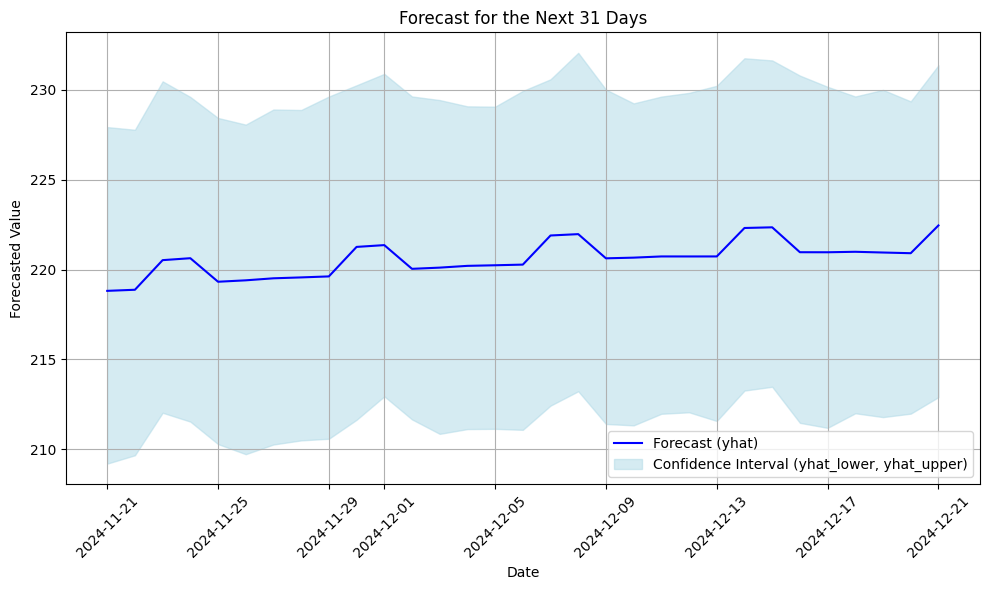

In [18]:
forecast_tail = forecast_dates.tail(31)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(forecast_tail['ds'], forecast_tail['yhat'], label='Forecast (yhat)', color='blue')
plt.fill_between(
    forecast_tail['ds'],
    forecast_tail['yhat_lower'],
    forecast_tail['yhat_upper'],
    color='lightblue',
    alpha=0.5,
    label='Confidence Interval (yhat_lower, yhat_upper)',
)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Forecasted Value')
plt.title('Forecast for the Next 31 Days')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

Getting Recommendation

- By default runs for today's date.
- Specific date can be passed as well, in which case this will be solely used to get the recommendation.

In [19]:
from datetime import datetime, timedelta

def get_recommendation(date=datetime.now()):
    # Ensure date is a datetime object
    if isinstance(date, str):
        date = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')

    ten_days_ago = date - timedelta(days=10)
    past_10_days_forecast = forecast_dates[(forecast_dates['ds'] < date) & (forecast_dates['ds'] > ten_days_ago)]['yhat'].mean()
    today_forecast = forecast_dates[forecast_dates['ds'] == date.strftime("%Y-%m-%d")]['yhat'].iloc[0]

    return today_forecast > past_10_days_forecast

get_recommendation(datetime.strptime('2024-25-11', '%Y-%d-%m').strftime('%Y-%m-%d %H:%M:%S'))
get_recommendation()

True

Recommendation Based on momentum

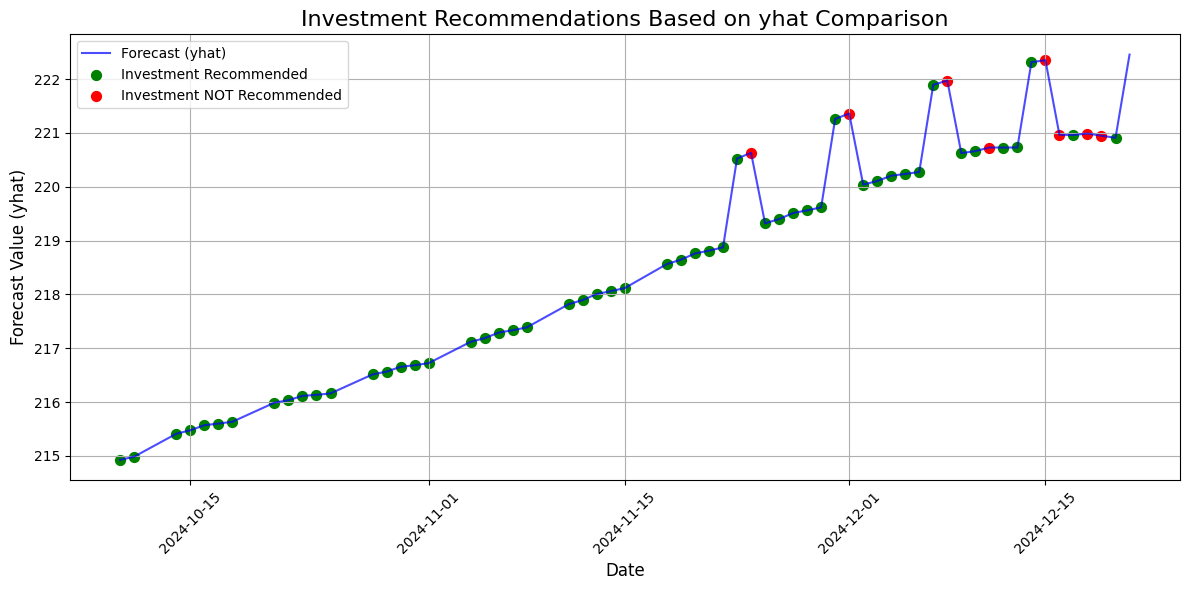

In [20]:
dt = forecast_dates.tail(61)

dt['recommendation'] = [
    'Recommended' if dt['yhat'].iloc[i] > dt['yhat'].iloc[i - 1] else 'Not Recommended'
    for i in range(1, len(dt))
] + ['No Comparison']  

plt.figure(figsize=(12, 6))

plt.plot(dt['ds'], dt['yhat'], label='Forecast (yhat)', color='blue', alpha=0.7)

plt.scatter(
    dt[dt['recommendation'] == 'Recommended']['ds'],
    dt[dt['recommendation'] == 'Recommended']['yhat'],
    color='green',
    label='Investment Recommended',
    s=50,
)

plt.scatter(
    dt[dt['recommendation'] == 'Not Recommended']['ds'],
    dt[dt['recommendation'] == 'Not Recommended']['yhat'],
    color='red',
    label='Investment NOT Recommended',
    s=50,
)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Forecast Value (yhat)', fontsize=12)
plt.title('Investment Recommendations Based on yhat Comparison', fontsize=16)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Recommendation based on Sentiment

In [22]:
# Normalize dates to remove times
llm_data['pub_date'] = pd.to_datetime(llm_data['pub_date']).dt.normalize()
forecast_dates['ds'] = pd.to_datetime(forecast_dates['ds'])

# Remove timezone information from 'pub_date' to match 'ds'
llm_data['pub_date'] = llm_data['pub_date'].dt.tz_localize(None)

# Debug: Check overlapping dates
print("Unique dates in forecast_dates:")
print(forecast_dates['ds'].dt.date.unique())

print("Unique dates in llm_data:")
print(llm_data['pub_date'].dt.date.unique())

# Merge after ensuring alignment
recommendation_data = forecast_dates.merge(
    llm_data[['pub_date', 'compound']],
    left_on='ds',
    right_on='pub_date',
    how='left'
)

# Define recommendation logic
recommendation_data['recommendation'] = recommendation_data['compound'].apply(
    lambda x: '+ve' if x > 0.05 else '-ve' if pd.notna(x) else 'No Data'
)

# Display sample
print(recommendation_data[['ds', 'compound', 'recommendation']].head())


Unique dates in forecast_dates:
[datetime.date(2013, 1, 2) datetime.date(2013, 1, 3)
 datetime.date(2013, 1, 4) ... datetime.date(2024, 12, 19)
 datetime.date(2024, 12, 20) datetime.date(2024, 12, 21)]
Unique dates in llm_data:
[datetime.date(2013, 1, 1) datetime.date(2013, 1, 2)
 datetime.date(2013, 1, 3) ... datetime.date(2024, 10, 2)
 datetime.date(2024, 10, 9) datetime.date(2024, 10, 11)]
          ds  compound recommendation
0 2013-01-02      0.02            -ve
1 2013-01-02      0.00            -ve
2 2013-01-03      1.00            +ve
3 2013-01-04       NaN        No Data
4 2013-01-07      0.65            +ve


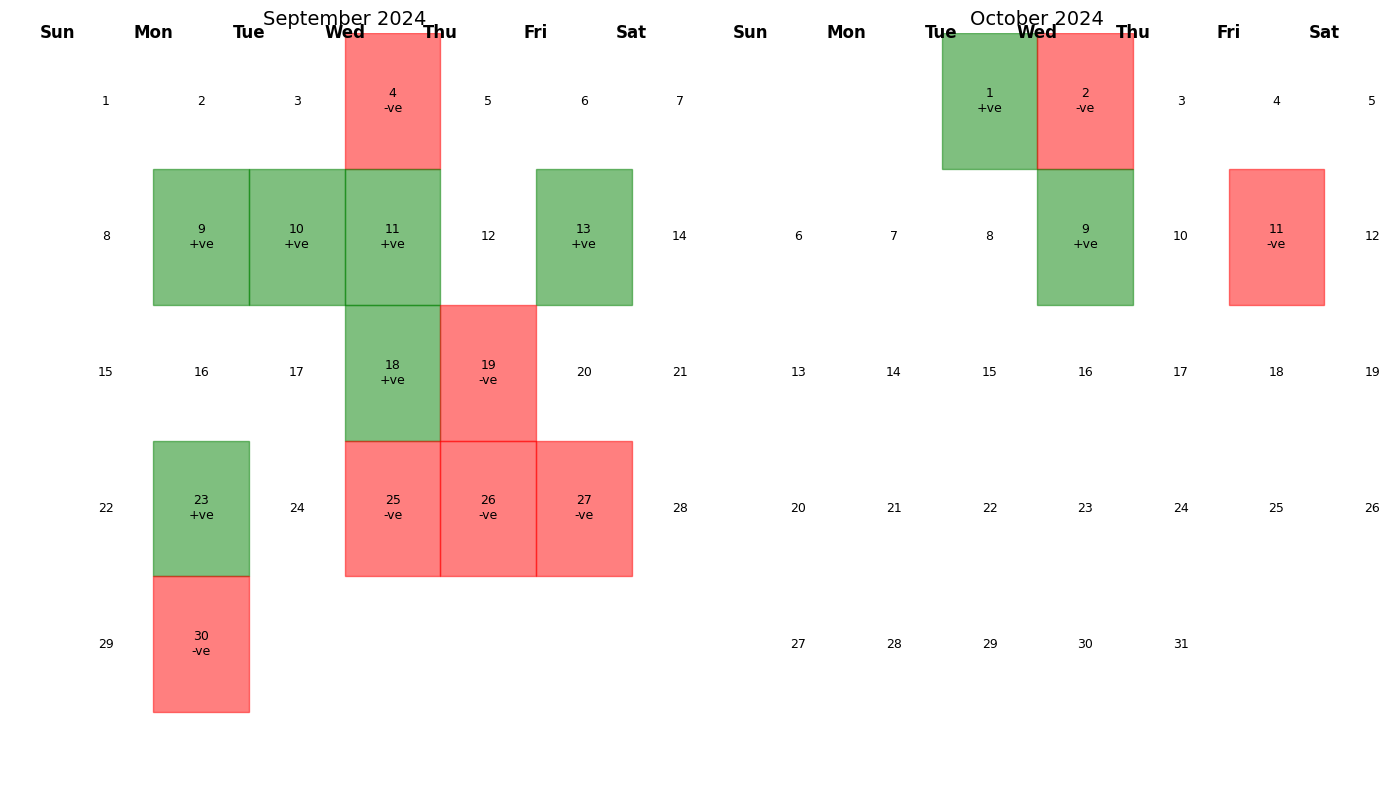

In [23]:
# Filter the last 5 months of data
recommendation_data['month'] = recommendation_data['ds'].dt.to_period('M')
last_5_months = recommendation_data['month'].unique()[-4:]
filtered_data = recommendation_data[recommendation_data['month'].isin(last_5_months)]

# Filter out months with only "No Data"
valid_months = []
for period in last_5_months:
    month_data = filtered_data[filtered_data['month'] == period]
    if (month_data['recommendation'] != 'No Data').any():
        valid_months.append(period)

# Create subplots for valid months
fig, axes = plt.subplots(len(valid_months) // 2 + len(valid_months) % 2, 2, figsize=(14, len(valid_months) * 4))
axes = axes.flatten()[:len(valid_months)]

for i, period in enumerate(valid_months):
    year, month = period.year, period.month
    ax = axes[i]
    
    # Create a calendar for the month
    cal = calendar.Calendar(firstweekday=6)
    month_days = cal.monthdayscalendar(year, month)

    # Prepare data for plotting
    month_data = filtered_data[filtered_data['month'] == period]
    plot_data = {day: 'No Data' for day in range(1, 32)}
    for _, row in month_data.iterrows():
        day = row['ds'].day
        plot_data[day] = row['recommendation']

    # Add weekday labels
    days_of_week = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    for col, day_name in enumerate(days_of_week):
        ax.text(col, len(month_days), day_name, ha='center', va='center', fontsize=12, weight='bold')

    # Plot days
    for row, week in enumerate(month_days):
        for col, day in enumerate(week):
            if day == 0:
                continue  # Skip empty cells
            recommendation = plot_data.get(day, 'No Data')

            # Determine color based on recommendation
            if recommendation == '+ve':
                color = 'green'
            elif recommendation == '-ve':
                color = 'red'
            else:
                color = None

            # Draw day cell with recommendation
            if color:
                ax.add_patch(plt.Rectangle((col, len(month_days) - row - 1), 1, 1, color=color, alpha=0.5))
                ax.text(col + 0.5, len(month_days) - row - 1 + 0.5,
                        f'{day}\n{recommendation}', ha='center', va='center', fontsize=9, color='black')
            else:
                ax.text(col + 0.5, len(month_days) - row - 1 + 0.5,
                        f'{day}', ha='center', va='center', fontsize=9, color='black')

    ax.set_xlim(-0.5, 6.5)
    ax.set_ylim(-0.5, len(month_days))
    ax.set_title(f'{calendar.month_name[month]} {year}', fontsize=14)
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


- Sentiment trends can vary within a single month. 
- **For example**:
    - September starts negatively (4th), improves mid-month (9th to 13th), and ends with more negative signals (25th onward).
    - October shows alternating sentiment without clear trends.

Downward Trend ,
- 1.0 Indicates Declining Forecast - Investment is not recommended.
- 0.0 Otherwise

In [24]:
n_days = 10

# Check for downward trends using rolling apply
forecast_dates['downward_trend'] = forecast_dates['yhat'].rolling(window=n_days).apply(
    lambda x: 1 if all(x[j] > x[j + 1] for j in range(len(x) - 1)) else 0,
    raw=True
)

not_recommended = forecast_dates[forecast_dates['downward_trend'] == 1]

print(not_recommended[['ds', 'yhat', 'downward_trend']])


             ds        yhat  downward_trend
33   2013-02-20   15.168640             1.0
34   2013-02-21   14.867407             1.0
35   2013-02-22   14.567184             1.0
36   2013-02-25   13.919727             1.0
37   2013-02-26   13.640423             1.0
...         ...         ...             ...
2945 2024-09-16  213.963939             1.0
2946 2024-09-17  213.811356             1.0
2947 2024-09-18  213.711082             1.0
2948 2024-09-19  213.567266             1.0
2949 2024-09-20  213.450533             1.0

[396 rows x 3 columns]


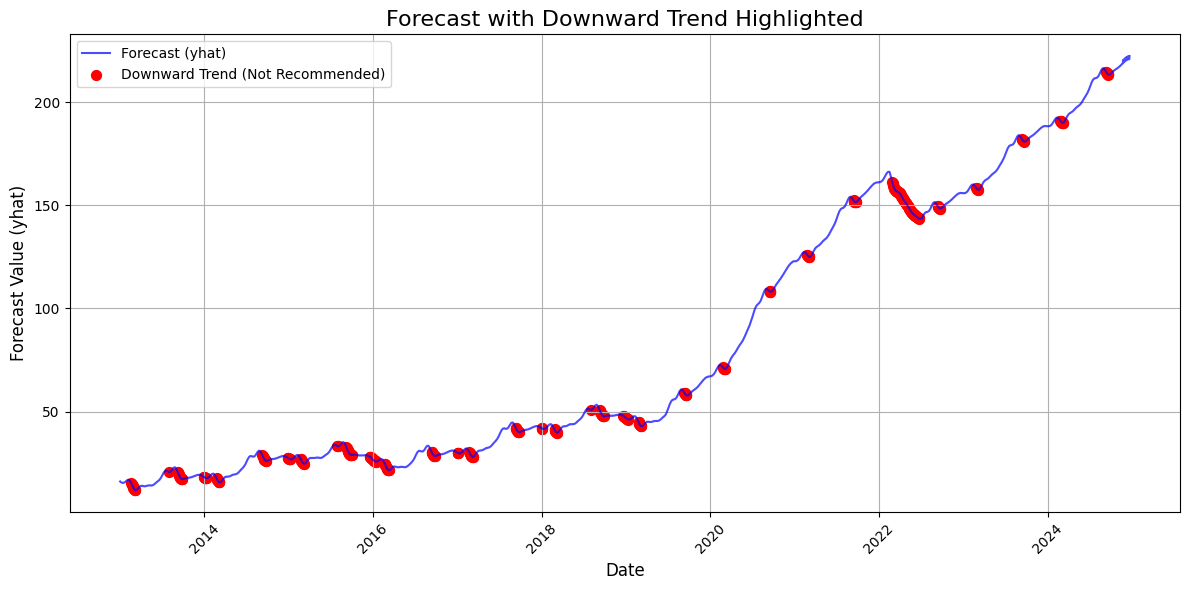

In [25]:
import matplotlib.pyplot as plt

forecast_dates = forecast_dates.copy()  

not_recommended = forecast_dates[forecast_dates['downward_trend'] == 1]

plt.figure(figsize=(12, 6))

plt.plot(forecast_dates['ds'], forecast_dates['yhat'], label='Forecast (yhat)', color='blue', alpha=0.7)
plt.scatter(not_recommended['ds'], not_recommended['yhat'], color='red', label='Downward Trend (Not Recommended)', s=50)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Forecast Value (yhat)', fontsize=12)
plt.title('Forecast with Downward Trend Highlighted', fontsize=16)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


#### Insights:

- Uptrend: Most of the forecast data shows a gradual increase over time, indicating a generally positive trajectory for the forecasted values.
- Downtrend (Not Recommended): The red points indicate periods where the rolling window detected a steady decline in the forecast. These periods might signal times where investment or action is less favorable.

#### Application:

- In practical scenarios (e.g., financial forecasting), the red points can be used as a signal to avoid investments or take caution during these timeframes.
- For non-financial use cases, the downward trends might indicate periods of concern or areas requiring further analysis or intervention.


Target Profitability

In [31]:
forecast_dates['ten_day_mean'] = forecast_dates['yhat'].rolling(window=10).mean()

profit_threshold = 1.01
forecast_dates['recommendation_target'] = forecast_dates['yhat'] > (forecast_dates['ten_day_mean'] * profit_threshold)
recommended = forecast_dates[forecast_dates['recommendation_target'] == True]
not_recommended = forecast_dates[forecast_dates['recommendation_target'] == False]
print(not_recommended[['ds', 'yhat', 'ten_day_mean']])

             ds        yhat  ten_day_mean
0    2013-01-02   16.077939           NaN
1    2013-01-03   15.929824           NaN
2    2013-01-04   15.794063           NaN
3    2013-01-07   15.687689           NaN
4    2013-01-08   15.597385           NaN
...         ...         ...           ...
3019 2024-12-17  220.961013    221.202579
3020 2024-12-18  220.987705    221.104335
3021 2024-12-19  220.946821    221.136669
3022 2024-12-20  220.908623    221.161410
3023 2024-12-21  222.453979    221.333984

[2150 rows x 3 columns]


In [32]:
import plotly.express as px
import plotly.graph_objects as go

# Create an interactive line plot
fig = go.Figure()

# Add the forecast line
fig.add_trace(go.Scatter(
    x=forecast_dates['ds'],
    y=forecast_dates['yhat'],
    mode='lines',
    name='Forecast (yhat)',
    line=dict(color='blue')
))

# Add recommended points
fig.add_trace(go.Scatter(
    x=recommended['ds'],
    y=recommended['yhat'],
    mode='markers',
    name='Investment Recommended',
    marker=dict(color='green', size=10, symbol='triangle-up')
))

# Add not recommended points
fig.add_trace(go.Scatter(
    x=not_recommended['ds'],
    y=not_recommended['yhat'],
    mode='markers',
    name='Investment NOT Recommended',
    marker=dict(color='red', size=8, symbol='circle')
))

# Add the profit threshold line
fig.add_trace(go.Scatter(
    x=forecast_dates['ds'],
    y=forecast_dates['ten_day_mean'] * profit_threshold,
    mode='lines',
    name='Profit Threshold',
    line=dict(color='orange', dash='dash')
))

fig.update_layout(
    title='Interactive Investment Recommendations',
    xaxis_title='Date',
    yaxis_title='Forecast Value (yhat)',
    template='plotly_white'
)

fig.show()


In [33]:
# get_recommendation() ## true / false (based on past 10 days)
# get_Current_months_sentiment() ## overall sentiment. Use overall_sentiment['compound']


In [34]:
# forecast_dates[['recommendation_target','downward_trend']] ## true / false , 0 , 1, nan
# dt['recommendation'] ## Recommended/ Not Recommended

In [35]:
def get_final_recommendation(
    recommendation_target, 
    downward_trend, 
    recommendation, 
    past_10_days_recommendation, 
    current_month_sentiment, 
    sentiment_weight=0.5, 
    trend_weight=0.2, 
    past_10_days_weight=0.15, 
    recommendation_target_weight=0.1, 
    simple_recommendation_weight=0.05
):
    """
    Function to decide final recommendation based on multiple components with weighted priorities.
    
    Parameters:
    recommendation_target (bool): Forecast-based recommendation target (True/False).
    downward_trend (float): 1.0 for downward trend, 0.0 or NaN otherwise.
    recommendation (str): "Recommended" or "Not Recommended" based on momentum.
    past_10_days_recommendation (bool): True if past 10 days recommend investment, False otherwise.
    current_month_sentiment (float): Compound sentiment score for the current month.
    sentiment_weight (float): Weight for sentiment score (default=0.5).
    trend_weight (float): Weight for downward trend component (default=0.2).
    past_10_days_weight (float): Weight for past 10 days recommendation (default=0.15).
    recommendation_target_weight (float): Weight for recommendation target (default=0.1).
    simple_recommendation_weight (float): Weight for simple recommendation (default=0.05).
    
    Returns:
    str: Final recommendation - "Recommended" or "Not Recommended".
    """
    # Scale sentiment to range between 0 and 1
    sentiment_score = max(0, min(1, current_month_sentiment))  # Clamp sentiment between 0 and 1
    
    # Normalize other components
    trend_score = 1.0 if downward_trend == 1.0 else 0.0
    recommendation_target_score = 1.0 if recommendation_target else 0.0
    past_10_days_score = 1.0 if past_10_days_recommendation else 0.0
    simple_recommendation_score = 1.0 if recommendation == "Recommended" else 0.0
    
    # Compute weighted average
    final_score = (
        sentiment_score * sentiment_weight +
        trend_score * trend_weight +
        recommendation_target_score * recommendation_target_weight +
        past_10_days_score * past_10_days_weight +
        simple_recommendation_score * simple_recommendation_weight
    )
    
    # Decide based on a threshold
    return "Recommended" if final_score >= 0.5 else "Not Recommended"


example_recommendation_target = forecast_dates[forecast_dates['ds']== datetime.now().strftime('%Y-%m-%d')]['recommendation_target'].iloc[0]
example_downward_trend = forecast_dates[forecast_dates['ds']== datetime.now().strftime('%Y-%m-%d')]['downward_trend'].iloc[0]
example_recommendation = dt[dt['ds'] == datetime.now().strftime('%Y-%m-%d')]['recommendation'].iloc[0]
example_past_10_days_recommendation = get_recommendation()
example_current_month_sentiment = get_Current_months_sentiment(list_of_keywords)

final_recommendation = get_final_recommendation(
    example_recommendation_target, 
    example_downward_trend, 
    example_recommendation, 
    example_past_10_days_recommendation, 
    example_current_month_sentiment
)

final_recommendation


Found 3643 articles in 2024-11
Found 19 articles in 2024-11 related to APPL


Summarizing: 100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [19:35<00:00, 61.85s/it]


Summarization complete.


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [14:09<00:00, 44.69s/it]


'Not Recommended'